### Example of Multi-label classification with PyTorch

Multi-label means that the same image can have associated several labels.

In other words: class are not exclusive

we will be using the NUS-WIDE dataset (a subset)

see: https://github.com/spmallick/learnopencv/blob/master/PyTorch-Multi-Label-Image-Classification-Image-Tagging/Pipeline.ipynb

In [1]:
import os
import time
import random
import numpy as np
from tqdm import tqdm
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# globals

IMG_FOLDER = "./nus_wide_images"

In [3]:
# Simple dataloader and label binarization
# that is converting test labels into binary arrays of length 27 (number of classes) with 1 in places of applicable labels).
class NusDataset(Dataset):
    def __init__(self, data_path, anno_path, transforms):
        self.transforms = transforms
        with open(anno_path) as fp:
            json_data = json.load(fp)
        samples = json_data['samples']
        self.classes = json_data['labels']

        self.imgs = []
        self.annos = []
        self.data_path = data_path
        print('loading annotations from:', anno_path)
        for sample in samples:
            self.imgs.append(sample['image_name'])
            self.annos.append(sample['image_labels'])
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        img_path = os.path.join(self.data_path, self.imgs[item])
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

    def __len__(self):
        return len(self.imgs)

In [4]:
# Let's take a look at the data we have. To do it we need to load the dataset without augmentations.
dataset_train = NusDataset(IMG_FOLDER, os.path.join(IMG_FOLDER , 'small_train.json'), None)
dataset_val = NusDataset(IMG_FOLDER, os.path.join(IMG_FOLDER , 'small_test.json'), None)

loading annotations from: ./nus_wide_images/small_train.json
loading annotations from: ./nus_wide_images/small_test.json


In [5]:
N_CLASSES = len(dataset_train.classes)

print(f"We have {N_CLASSES} classes...")

We have 27 classes...


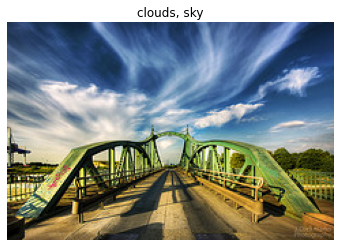

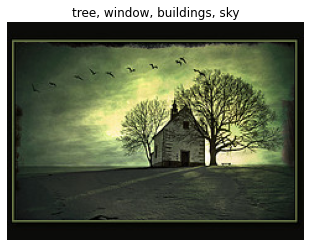

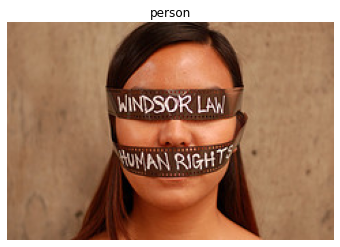

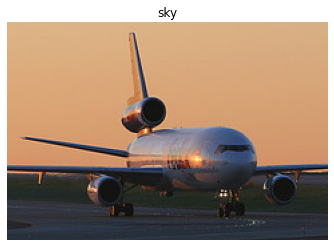

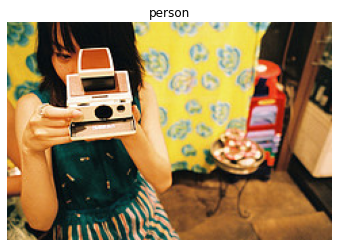

In [6]:
# A simple function for visualization.
def show_sample(img, binary_img_labels):
    # Convert the binary labels back to the text representation.    
    img_labels = np.array(dataset_val.classes)[np.argwhere(binary_img_labels > 0)[:, 0]]
    plt.imshow(img)
    plt.title("{}".format(', '.join(img_labels)))
    plt.axis('off')
    plt.show()

for sample_id in range(5):
    show_sample(*dataset_val[sample_id])

In [7]:
# Model class definition
# we can choose a different backbone

# Use the torchvision's implementation of EFFNetB0
# but add FC layer for a different number of classes (27) 
# and a Sigmoid for multi-label (not exclusive)
class EFFNetB0(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        effnetb0 = models.efficientnet_b0(pretrained=True)
        effnetb0.classifier[1] = nn.Sequential(nn.Linear(1280, n_classes, bias=True))
        
        self.base_model = effnetb0
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [8]:
# transforms definition
IMAGE_SIDE = 224

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIDE, IMAGE_SIDE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                            shear=None, resample=False, 
                            fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

/home/datascience/conda/computervision_p37_gpu_v1/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1362: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"
/home/datascience/conda/computervision_p37_gpu_v1/lib/python3.7/site-packages/torchvision/transforms/transforms.py:1376: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  "Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead"


In [20]:
# Initialize the dataloaders for training.
BATCH_SIZE = 32
NUM_WORKERS = 4

train_annotations = os.path.join(IMG_FOLDER, 'small_train.json')
val_annotations = os.path.join(IMG_FOLDER, 'small_test.json')

train_dataset = NusDataset(IMG_FOLDER, train_annotations, train_transform)
val_dataset = NusDataset(IMG_FOLDER, val_annotations, val_transform)

train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                               num_workers=NUM_WORKERS, shuffle=True, drop_last=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

loading annotations from: ./nus_wide_images/small_train.json
loading annotations from: ./nus_wide_images/small_test.json


In [21]:
print("Datasets:")
print(f"We have {len(train_dataset)} samples in train dataset")
print(f"We have {len(val_dataset)} samples in validation dataset")

Datasets:
We have 5000 samples in train dataset
We have 1000 samples in validation dataset


In [22]:
# Initialize the model
device = torch.device('cuda')

model = EFFNetB0(N_CLASSES)

model = model.to(device)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has: {count_parameters(model)} trainable params...")

The model has: 4042135 trainable params...


In [24]:
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [25]:
EPOCHS = 16
# lowered respect to tresnet
LR = 2e-4

# Loss
criterion = nn.BCELoss()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Logs - Helpful for plotting after training finishes
train_logs = {"loss": [], "accuracy": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "time": []}

In [26]:
def train_one_epoch(train_data_loader):

    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    for images, labels in tqdm(train_data_loader):

        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Resetting Gradients
        optimizer.zero_grad()

        # Forward
        preds = model(images)

        # Calculating Loss
        _loss = criterion(preds, labels.type(torch.float))
        loss = _loss.item()
        epoch_loss.append(loss)

        # Backward
        _loss.backward()
        optimizer.step()

    # Overall Epoch Results 
    total_time = time.time() - start_time

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)

    # Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["time"].append(total_time)
    
    return epoch_loss, total_time

In [27]:
def val_one_epoch(val_data_loader):

    # Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    for images, labels in val_data_loader:

        # Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward
        preds = model(images)

        # Calculating Loss
        _loss = criterion(preds, labels.type(torch.float))
        loss = _loss.item()
        epoch_loss.append(loss)

    # Overall Epoch Results
    total_time = time.time() - start_time

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)

    val_logs["loss"].append(epoch_loss)
    val_logs["time"].append(total_time)

    return epoch_loss, total_time 

In [28]:
#
# Here we do the training loop
#
for epoch in range(EPOCHS):
    # Training
    loss, _time = train_one_epoch(train_data_loader)

    print()
    print(
        f"Training: Epoch {epoch}, Loss : {round(loss, 4)}, Time : {round(_time, 1)}"
    )

    # Validation
    loss, _time, = val_one_epoch(val_data_loader)

    print()
    print(
        f"Validation: Epoch {epoch}, Loss : {round(loss, 4)}, Time : {round(_time, 1)}"
    )

100%|██████████| 156/156 [00:20<00:00,  7.79it/s]


Training: Epoch 0, Loss : 0.2459, Time : 20.0



Validation: Epoch 0, Loss : 0.1665, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.78it/s]


Training: Epoch 1, Loss : 0.1454, Time : 20.0



Validation: Epoch 1, Loss : 0.1451, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.79it/s]


Training: Epoch 2, Loss : 0.1282, Time : 20.0



Validation: Epoch 2, Loss : 0.138, Time : 1.6


100%|██████████| 156/156 [00:19<00:00,  7.80it/s]


Training: Epoch 3, Loss : 0.1165, Time : 20.0



Validation: Epoch 3, Loss : 0.1359, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.80it/s]


Training: Epoch 4, Loss : 0.1092, Time : 20.0



Validation: Epoch 4, Loss : 0.1347, Time : 1.7


100%|██████████| 156/156 [00:19<00:00,  7.81it/s]


Training: Epoch 5, Loss : 0.1016, Time : 20.0



Validation: Epoch 5, Loss : 0.1334, Time : 1.7


100%|██████████| 156/156 [00:20<00:00,  7.78it/s]


Training: Epoch 6, Loss : 0.0965, Time : 20.0



Validation: Epoch 6, Loss : 0.1335, Time : 1.6


100%|██████████| 156/156 [00:19<00:00,  7.80it/s]


Training: Epoch 7, Loss : 0.0911, Time : 20.0



Validation: Epoch 7, Loss : 0.1352, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.80it/s]


Training: Epoch 8, Loss : 0.084, Time : 20.0



Validation: Epoch 8, Loss : 0.1357, Time : 1.6


100%|██████████| 156/156 [00:19<00:00,  7.81it/s]


Training: Epoch 9, Loss : 0.079, Time : 20.0



Validation: Epoch 9, Loss : 0.1364, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.80it/s]


Training: Epoch 10, Loss : 0.0759, Time : 20.0



Validation: Epoch 10, Loss : 0.1407, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.76it/s]


Training: Epoch 11, Loss : 0.0712, Time : 20.1



Validation: Epoch 11, Loss : 0.1443, Time : 1.6


100%|██████████| 156/156 [00:19<00:00,  7.80it/s]


Training: Epoch 12, Loss : 0.066, Time : 20.0



Validation: Epoch 12, Loss : 0.1479, Time : 1.7


100%|██████████| 156/156 [00:20<00:00,  7.77it/s]


Training: Epoch 13, Loss : 0.0628, Time : 20.1



Validation: Epoch 13, Loss : 0.1476, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.79it/s]


Training: Epoch 14, Loss : 0.0577, Time : 20.0



Validation: Epoch 14, Loss : 0.1562, Time : 1.6


100%|██████████| 156/156 [00:20<00:00,  7.78it/s]


Training: Epoch 15, Loss : 0.0555, Time : 20.1



Validation: Epoch 15, Loss : 0.1581, Time : 1.6


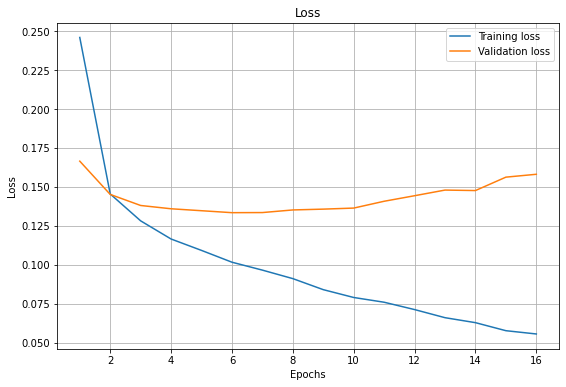

In [29]:
vet_epochs = np.arange(1, EPOCHS+1, 1)

# Loss
plt.figure(figsize=(9, 6))
plt.title("Loss")
plt.plot(vet_epochs, train_logs["loss"], label="Training loss")
plt.plot(vet_epochs, val_logs["loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

La curva riportata sopra è un chiaro esempio di overfitting: dopo la epoch 6 la training loss continua a diminuire mentre la validation loss comincia a salire